# Pediatric Model Without Initialization

Utilizes empty model.

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import torch.nn.functional as F

## Model Creation

Same code for the model

In [2]:
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

num_classes = 2
custom_model = CustomCNNModel(num_classes=num_classes)

Print the structure of the model

In [3]:
print(custom_model)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Print frozen and trainable parameters of model

In [4]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

conv1.weight: Trainable
conv1.bias: Trainable
conv2.weight: Trainable
conv2.bias: Trainable
conv3.weight: Trainable
conv3.bias: Trainable
fc1.weight: Trainable
fc1.bias: Trainable
fc2.weight: Trainable
fc2.bias: Trainable
fc3.weight: Trainable
fc3.bias: Trainable


## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [5]:
# with zipfile.ZipFile("original_data.zip", 'r') as zip_ref:
#     zip_ref.extractall("")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="../pediatric_dataset/preprocessed_medium", transform=transform)

class_indices = {class_name: [] for class_name in dataset.classes}
for idx, (image, label) in enumerate(dataset):
    class_indices[dataset.classes[label]].append(idx)

for x in class_indices:
    print(f"{x}: {len(class_indices[x])} images")

train_indices = []
test_indices = []

for class_name in dataset.classes:
    indices = class_indices[class_name]
    train_indices.extend(indices[:int(len(indices)*.75)])
    test_indices.extend(indices[int(len(indices)*.75):len(indices)-1])

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

normal: 200 images
pneumonia: 200 images


In [7]:
print(dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}


In [8]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 300
Test dataset size: 98


In [9]:
from collections import Counter

def count_classes_in_subset(subset, original_dataset):
    subset_labels = [original_dataset.targets[idx] for idx in subset.indices]
    class_counts = Counter(subset_labels)
    class_name_counts = {original_dataset.classes[idx]: count for idx, count in class_counts.items()}
    return class_name_counts

train_class_counts = count_classes_in_subset(train_dataset, dataset)
test_class_counts = count_classes_in_subset(test_dataset, dataset)

print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: {'normal': 150, 'pneumonia': 150}
Test class counts: {'normal': 49, 'pneumonia': 49}


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


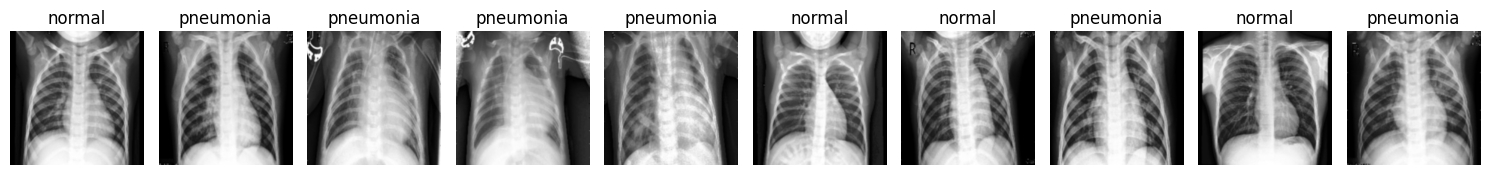

In [11]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Training Model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [13]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, custom_model.parameters()), lr=1e-3, weight_decay=1e-2)

num_epochs = 15
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

Device using for training: cuda


Epoch [1/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.80s/batch]


Epoch [1/15], Train Loss: 0.7524, Train Accuracy: 47.00%, Test Loss: 0.6917, Test Accuracy: 50.00%


Epoch [2/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09batch/s]


Epoch [2/15], Train Loss: 0.6749, Train Accuracy: 56.00%, Test Loss: 0.6144, Test Accuracy: 65.31%


Epoch [3/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68batch/s]


Epoch [3/15], Train Loss: 0.5767, Train Accuracy: 70.00%, Test Loss: 0.3961, Test Accuracy: 86.73%


Epoch [4/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72batch/s]


Epoch [4/15], Train Loss: 0.4375, Train Accuracy: 78.00%, Test Loss: 0.2274, Test Accuracy: 90.82%


Epoch [5/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64batch/s]


Epoch [5/15], Train Loss: 0.3403, Train Accuracy: 83.00%, Test Loss: 0.5393, Test Accuracy: 61.22%


Epoch [6/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36batch/s]


Epoch [6/15], Train Loss: 0.3625, Train Accuracy: 82.67%, Test Loss: 0.3231, Test Accuracy: 85.71%


Epoch [7/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/batch]


Epoch [7/15], Train Loss: 0.2780, Train Accuracy: 88.33%, Test Loss: 0.5643, Test Accuracy: 80.61%


Epoch [8/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/batch]


Epoch [8/15], Train Loss: 0.2678, Train Accuracy: 88.33%, Test Loss: 0.4306, Test Accuracy: 81.63%


Epoch [9/15]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/batch]


Epoch [9/15], Train Loss: 0.2975, Train Accuracy: 87.67%, Test Loss: 0.3394, Test Accuracy: 82.65%


Epoch [10/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/batch]


Epoch [10/15], Train Loss: 0.2155, Train Accuracy: 91.67%, Test Loss: 0.4345, Test Accuracy: 82.65%


Epoch [11/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/batch]


Epoch [11/15], Train Loss: 0.1947, Train Accuracy: 91.67%, Test Loss: 0.3675, Test Accuracy: 82.65%


Epoch [12/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/batch]


Epoch [12/15], Train Loss: 0.1734, Train Accuracy: 93.67%, Test Loss: 0.3261, Test Accuracy: 86.73%


Epoch [13/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/batch]


Epoch [13/15], Train Loss: 0.1746, Train Accuracy: 92.33%, Test Loss: 0.3185, Test Accuracy: 82.65%


Epoch [14/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/batch]


Epoch [14/15], Train Loss: 0.1528, Train Accuracy: 93.00%, Test Loss: 0.3533, Test Accuracy: 85.71%


Epoch [15/15]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/batch]


Epoch [15/15], Train Loss: 0.1574, Train Accuracy: 91.67%, Test Loss: 0.2676, Test Accuracy: 84.69%


## Evaluation

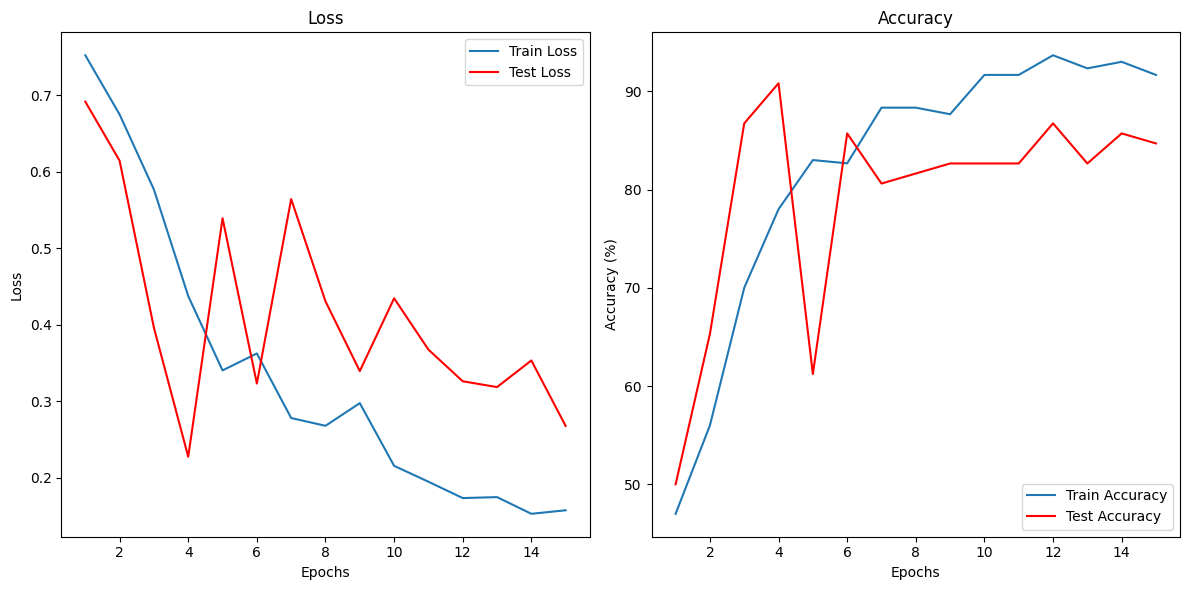

In [15]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
custom_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8469
Precision: 0.8591
Recall: 0.8469
F1 Score: 0.8456
